# 6.1 Классификация.Соискатели

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Отправьте результат нам

### Полезная литература

- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Коллаборативная фильтрация - рекомендательная система](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F)
- [Метрики расстояний - косинусная, минковского, проклятье размерности ](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf)
- [Offtop: метрики качества рекомендаьельных систем](https://habrahabr.ru/company/dca/blog/281066/)

## kNN - ближайшие соседи (15 баллов)

Рассмотрим задачу из соревнования [Amazon Employee Access Challenge](https://www.kaggle.com/c/amazon-employee-access-challenge).

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import scale

In [4]:
df = pd.read_csv('../../data/amazon.csv.gz')
df.head()
# ACTION - это целевой признак

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Обратим внимание, что выборка не сбалансированная. В качестве метрики качества будем использовть [f1-score](https://en.wikipedia.org/wiki/F1_score). 
$$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

$$precision = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$

0.9421099209618847


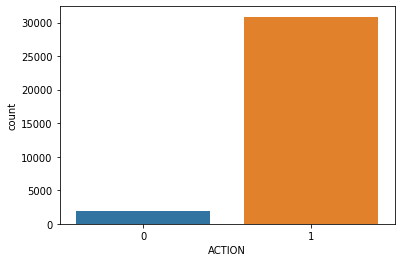

In [5]:
print(df['ACTION'].mean())
sns.countplot('ACTION', data=df)

In [6]:
# число значений у признаков
for col_name in df.columns:
    print(col_name, len(df[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [7]:
X = df.drop(['ACTION'], axis=1)
y = df['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)

# Baseline (4 балла)

Сразу проверим как ведет себя kNN на неподготовленных данных и без тюнинга. Зафиксируйте `n_neighbors=5`, `p=2`. 

- создайте экземпляр `KNeighborsClassifier` с указанными параметрами, обучите его методом `fit` и предскажите значения `predict` для треничровчных данных `X_test`.
- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Обратите внимание на confusion matrix. Какой вывод вы можете сделать из неё? Вспомните лекцию и значение ошибок 1 и 2 рода.

???Если StratifiedKFold всегда делит выборку равномерно, то почему бы всегда его не использовать?

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [103]:
X= df.head(100).drop(['ACTION'],axis=1)
y= df.head(100)['ACTION']

In [90]:
y.value_counts()

1    94
0     6
Name: ACTION, dtype: int64

In [117]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

In [118]:
for train_index, test_index in skf.split(X, y):    
    y_train, y_test = y[train_index], y[test_index]
    print(y_train.value_counts())
    print(y_test.value_counts())
    print('---------')

1    62
0     4
Name: ACTION, dtype: int64
1    32
0     2
Name: ACTION, dtype: int64
---------
1    63
0     4
Name: ACTION, dtype: int64
1    31
0     2
Name: ACTION, dtype: int64
---------
1    63
0     4
Name: ACTION, dtype: int64
1    31
0     2
Name: ACTION, dtype: int64
---------


In [112]:
kf = KFold(n_splits=3, shuffle=True)

In [113]:
for train_index, test_index in kf.split(X, y):    
    y_train, y_test = y[train_index], y[test_index]
    print(y_train.value_counts())
    print(y_test.value_counts())
    print('---------')

1    63
0     3
Name: ACTION, dtype: int64
1    31
0     3
Name: ACTION, dtype: int64
---------
1    62
0     5
Name: ACTION, dtype: int64
1    32
0     1
Name: ACTION, dtype: int64
---------
1    63
0     4
Name: ACTION, dtype: int64
1    31
0     2
Name: ACTION, dtype: int64
---------


In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)
print(y_train.value_counts())
print(y_test.value_counts())

1    62
0     5
Name: ACTION, dtype: int64
1    32
0     1
Name: ACTION, dtype: int64


In [102]:
#"-------------------------"

In [119]:
X= df.drop(['ACTION'],axis=1)
y= df['ACTION']

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

In [121]:
clf = KNeighborsClassifier(n_neighbors=5, p=2)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [122]:
y_pred = clf.predict(X_test).astype('int')

In [123]:
#отчет классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.34      0.09      0.14       614
           1       0.95      0.99      0.97     10200

    accuracy                           0.94     10814
   macro avg       0.64      0.54      0.55     10814
weighted avg       0.91      0.94      0.92     10814



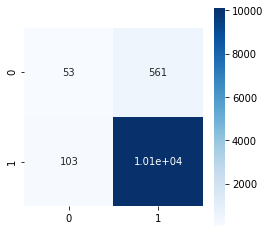

In [124]:
plt.figure(figsize=(4,4)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')

Выводы:
- плотность 0 очень низкая, соответственно f1 тоже низкая
- точность предсказания 0 очень нищкая

При фиксированном `n_neighbors=10` проверьте значение метрики на кроссвалидации на 5-фолдах для разных значений `p` из `(1,2,4,6)`. При каком значение `p` метрика достигает максимума?

При кроссвалидации у вас будет получаться N разных значений метрики. Выводите среднее значение и стандартное отклонение.

??? Я правильно понимаю, что р=1 это Манхэттеновское расстояние, р=2 Эвклидово, а все остальное это Минковский? Тогда зачем больше 3х значений?

In [125]:
from sklearn.model_selection import GridSearchCV

In [ ]:
clf = KNeighborsClassifier()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

%time scores = cross_val_score(clf, X, y, cv=cv)

print("Accuracy: {}".format(scores.mean()))

In [133]:
params = {
            "n_neighbors": [10], 
            "p": [1,2,4,6]
         }

cv = KFold(n_splits=5, shuffle=True, random_state=42)

search = GridSearchCV(KNeighborsClassifier(), params, cv=cv, verbose=2,n_jobs=-1)                    

%time search.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 209 ms, sys: 121 µs, total: 209 ms
Wall time: 26 s


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   25.9s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [10], 'p': [1, 2, 4, 6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

BEST: score=0.9407366967801938, params={'n_neighbors': 10, 'p': 1}


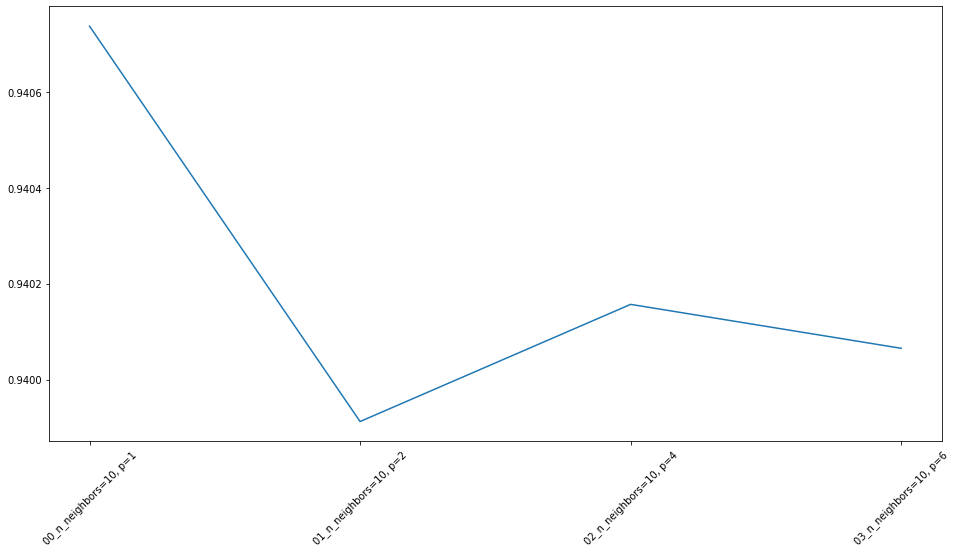

In [134]:
x_ticks = ["{:02d}_n_neighbors={}, p={}".format(i, p['n_neighbors'], p['p']) for i,p in enumerate(search.cv_results_['params'])]

plt.figure(figsize=(16,8))
plt.plot(x_ticks, search.cv_results_['mean_test_score'])
_ =plt.xticks(rotation=45)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

Отчет классификации стал еще хуже:

              precision    recall  f1-score   support

           0       0.30      0.04      0.07       614
           1       0.95      0.99      0.97     10200

    accuracy                           0.94     10814
   macro avg       0.62      0.52      0.52     10814
weighted avg       0.91      0.94      0.92     10814



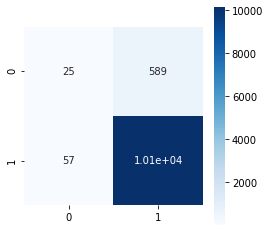

In [141]:
clf = KNeighborsClassifier(n_neighbors=search.best_params_['n_neighbors'], p=search.best_params_['p'])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test).astype('int')

print(classification_report(y_test, y_pred))

plt.figure(figsize=(4,4))
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.3g')

# Счетчики (6 баллов)

Очевидно, что предсказывать лейбл объекта, используя при этом метрический алгоритм на категориальных признаках - это ОЧЕНЬ странная затея. Не удивительно что качество ужасное. Необходимо каким-то образом заменить категориальные признаки вещественными:

- OneHotEncoding - это когда для каждого признака создают другие N бинарных признаков, где N - это количество категорий у категориального признака.
- Счетчики - об это написано в статье http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx.

Мы реализуем алгоритм Счетчиков. Его нет в sklearn, поэтому придется реализовать самому. 

Для каждого категориального признака создайте 3 других признака:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`successes` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

Обучение надо проводить только по новым признакам. Изначальные мы не используем.

Подсказка - вам нужно для каждой колонки посчитать 2 аггрегации - сумму и количество. Для замены конкретного значения посчитанным используйте функцию apply над датафреймом. Простое решение займет около 10 строк кода.

![](http://images6.fanpop.com/image/photos/38600000/taiga-iamyourenemy-38620719-282-160.gif)

??? Тут count не представляет порядок? Чем больше тем важнее/лучше?

??? А как мы получим successes у нового объекта, когда будем предсказыать на новых данных там же "у" не известен?

??? Как получены константы 1 и 2? (successes + 1) / (counts + 2).

In [240]:
df5 = df.head(10)[['ACTION','ROLE_FAMILY']]
df5

,ACTION,ROLE_FAMILY
0,1,290919
1,1,308574
2,1,19721
3,1,290919
4,1,19793
5,0,19721
6,1,118295
7,1,118638
8,1,4673
9,1,19721


In [241]:
#data = pd.DataFrame(index=df.head().index)

def CountAndSucc(df, df_counts, col_name):
    c = df[col_name].apply(lambda value: df_counts[value].sum()) #сумма встречающихся значений 0 и 1
    s = df[col_name].apply(lambda value: df_counts[value].iloc[1]) #количество значения при у=1
    f = (s+1)/(c+2)
    return [c,s,f]
    
for col_name in df5.columns:
    if col_name == 'ACTION':
        continue
    df_counts = df5.groupby(['ACTION',col_name])[col_name].count().unstack().fillna(0)# таблица, где именования столбцов это уникальные значения col_name, а в строках количество повторений при у = {0,1} 
    df5[col_name+'_count'], df5[col_name+'_successes'], df5[col_name+'_flattened'] = CountAndSucc(df5,df_counts,col_name)  
    #df5[col_name+'_count'] = df5[col_name].apply(lambda value: df_counts[value].sum()) #сумма встречающихся значений 0 и 1
    #df5[col_name+'_successes'] = df5[col_name].apply(lambda value: df_counts[value].iloc[1]) #количество значения при у=1
     

In [242]:
df5

,ACTION,ROLE_FAMILY,ROLE_FAMILY_count,ROLE_FAMILY_successes,ROLE_FAMILY_flattened
0,1,290919,2.0,2.0,0.750000
1,1,308574,1.0,1.0,0.666667
2,1,19721,3.0,2.0,0.600000
3,1,290919,2.0,2.0,0.750000
4,1,19793,1.0,1.0,0.666667
5,0,19721,3.0,2.0,0.600000
6,1,118295,1.0,1.0,0.666667
7,1,118638,1.0,1.0,0.666667
8,1,4673,1.0,1.0,0.666667
9,1,19721,3.0,2.0,0.600000


In [216]:
for col_name in df5.columns:
    df5_ = df5.groupby(['ACTION',col_name])[col_name].count().unstack().fillna(0)
df5_

ROLE_FAMILY,4673,19721,19793,118295,118638,290919,308574
ACTION,,,,,,,
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2.0,1.0,1.0,1.0,2.0,1.0


Проверьте какое качество теперь получается на кроссвалидации для новых данных.

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество.

# Co-co-co-combo (5 баллов)

Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i < j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [244]:
df_combo = df.copy()

# ТУТ ВАШ КОД

In [0]:
data_combo = pd.DataFrame(index=df_combo.index)
for col_name in df_combo.columns:
    if col_name == 'ACTION':
        continue
    # тут ваш код

In [246]:
df6 = df.head(10)[['ACTION','ROLE_FAMILY','ROLE_CODE','ROLE_TITLE']]
df6

,ACTION,ROLE_FAMILY,ROLE_CODE,ROLE_TITLE
0,1,290919,117908,117905
1,1,308574,118539,118536
2,1,19721,117880,117879
3,1,290919,118322,118321
4,1,19793,119325,119323
5,0,19721,118570,118568
6,1,118295,118982,118980
7,1,118638,126822,126820
8,1,4673,128231,128230
9,1,19721,117880,117879


ROLE_FAMILY_DESC#ROLE_FAMILY

117906#290919

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество. Не похоже ли это на переобусение?

Внимание! Обучение на этом этапе может быть долгим. На i5 16GB кроссвалидация на 5 фолдах заняла 30 минут!